# Algorithm 2

### PART 1 -  
#### Execute KMeans. 
Try to find automatticaly the 'elbow' - the best K results ( withour relating to the daily hours or to the number of resources).

### PART 2 - 
#### Order The Clusters.
 * 2a- Index all datapoints (jobs) in a cluster with the same index, when indexing is according to the distance between the clusters.
 * 2b- Greedy - Execute Shortest Path algorithm at each cluster, connect the cluster by the closest datapoints (jobs). (Index each datapoint with different index)
 * 2c - small clusters - execute cluster of clusters

In [1]:
import sys
import numpy as np # used for scientific computing\n",
import pandas as pd # used for data analysis and manipulation\n",
import matplotlib.pyplot as plt # used for visualization and plotting\n",
import matplotlib.cm as cm
import math
from sklearn.cluster import KMeans 
import heapq
from sklearn.preprocessing import MinMaxScaler
import warnings

In [2]:
name_of_file = 'fourth_dataset'
# export_results = True => export excel with results. otherwise not.
# Give the option to analyze the algorithms without exporting the results
export_results = False

In [3]:
# read the data
df = pd.read_excel(f'../Data/{name_of_file}.xlsx')

In [4]:
# verify the data
df

,_,Id,AppointmentNumber,Latitude,Longitude,IDC_Index__c,EarliestStartTime,DurationInMinutes
0,[ServiceAppointment],08p4L000000lKo4QAE,SA-5319,19.460891,-99.139634,NaN,2021-12-21T00:00:00.000+0000,14
1,[ServiceAppointment],08p4L000000lKo5QAE,SA-5320,19.368634,-99.145334,NaN,2021-12-21T00:00:00.000+0000,14
2,[ServiceAppointment],08p4L000000lKoCQAU,SA-5327,19.493341,-99.190447,NaN,2021-12-21T00:00:00.000+0000,14
3,[ServiceAppointment],08p4L000000lKoDQAU,SA-5328,19.462779,-99.135322,NaN,2021-12-21T00:00:00.000+0000,14
4,[ServiceAppointment],08p4L000000lKo9QAE,SA-5324,19.487029,-99.198889,NaN,2021-12-21T00:00:00.000+0000,14
...,...,...,...,...,...,...,...,...
1569,[ServiceAppointment],08p4L000000lKqvQAE,SA-5496,19.410017,-99.175183,NaN,2021-12-21T00:00:00.000+0000,14
1570,[ServiceAppointment],08p4L000000lKqwQAE,SA-5497,19.404777,-99.169003,NaN,2021-12-21T00:00:00.000+0000,14
1571,[ServiceAppointment],08p4L000000lKqsQAE,SA-5493,19.453365,-99.130240,NaN,2021-12-21T00:00:00.000+0000,14
1572,[ServiceAppointment],08p4L000000lKqtQAE,SA-5494,19.452480,-99.145865,NaN,2021-12-21T00:00:00.000+0000,14


In [5]:
def plot(c): 
    plt.scatter(df['Latitude'], df['Longitude'], color=c)

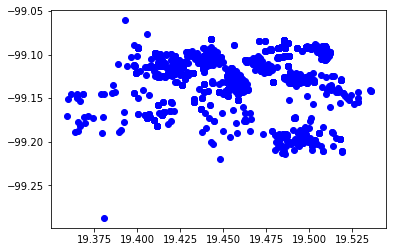

In [6]:
# map of the jobs
plot('blue')

In [7]:
# extract the relvent columns
dataset = np.array(df[['Latitude', 'Longitude']])

# PART 1 - KMEANS

finding the elbow is the method to find the best K. 
The solution is not optimal which means it is not return the best result any time.
In contrast, the result will be always close to the truth and the small error may not affect on our results drastically.

In [8]:
def finding_the_elbow(inertia_lst):
    """
    Finding the elbow - means to find the best K for the K means according to the inertia.
    The optimal solution is available only manually. 
    This function return a good K automatically.(not always the optimal) 
    """
    length = len(inertia_lst) - 1

    # delta_1: index=0 -> #cluster=2 -> best_k_idx=1
    delta_1 = [inertia_lst[i] - inertia_lst[i+1] for i in range(length)]

    # delta_2: index 0 -> #cluster=3 -> best_k_idx=2
    delta_2 = [delta_1[i] - delta_1[i+1] for i in range(length - 1)]

    strength = [(i, delta_2[i+1] - delta_1[i+2]) for i in range(length - 2) if delta_1[i+1] >= 0 and delta_2[i+1] >= 0]

    best_k_idx = max(strength,key=lambda t: t[1])[0] + 2
    return best_k_idx

In [9]:
def choose_k(Ks):
    """
    Choosing a good k from the given list of Ks
    Return - 
    - best_k_idx
    - inertia_lst - to represent that choosing make sense
    """
    # execute KMeans for each K in Ks
    inertia_lst = []
    for k in Ks:
        kmeans = KMeans(n_clusters=k, random_state=0)
        # fit the data
        _ = kmeans.fit_predict(dataset)
        # save inertia
        inertia_lst.append(kmeans.inertia_)
    
    best_k_idx = finding_the_elbow(inertia_lst)
    
    return best_k_idx, inertia_lst

In [10]:
# K to check for the KMeans
Ks = [k for k in range(4, 150)]
best_k_idx, inertia_lst = choose_k(Ks)
best_k = Ks[best_k_idx]

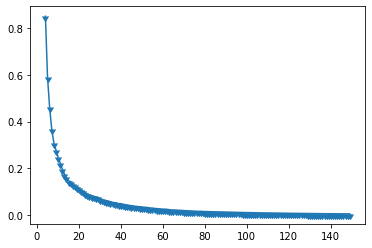

In [11]:
# plot inertia as function of number of clusers (k)
plt.plot(Ks, inertia_lst, marker=11)

In [12]:
# get the best KMeans , n_clusters=best_k
best_kmeans = KMeans(n_clusters=best_k, random_state=0)
# get labels 
labels = best_kmeans.fit_predict(dataset)

In [13]:
def seperate_instances_to_clusters(dataset, labels, best_k):
    """
    return dictionary {key = cluster_number , value = list of instances in this cluster}
    """
    # init dictionary
    dict_of_clusters = {cluster: [] for cluster in range(best_k)}

    for idx, instance in enumerate(dataset):
        dict_of_clusters[labels[idx]].append(instance)
    
    return dict_of_clusters

In [14]:
dict_of_clusters = seperate_instances_to_clusters(dataset, labels, best_k)

In [15]:
# print cluster sizes
for cluster, instances in dict_of_clusters.items():
    print(f'*Cluster {cluster}: {len(instances)} jobs.')
    print('-------')

*Cluster 0: 221 jobs.
-------
*Cluster 1: 97 jobs.
-------
*Cluster 2: 74 jobs.
-------
*Cluster 3: 124 jobs.
-------
*Cluster 4: 152 jobs.
-------
*Cluster 5: 135 jobs.
-------
*Cluster 6: 128 jobs.
-------
*Cluster 7: 182 jobs.
-------
*Cluster 8: 137 jobs.
-------
*Cluster 9: 24 jobs.
-------
*Cluster 10: 126 jobs.
-------
*Cluster 11: 42 jobs.
-------
*Cluster 12: 29 jobs.
-------
*Cluster 13: 102 jobs.
-------
*Cluster 14: 1 jobs.
-------


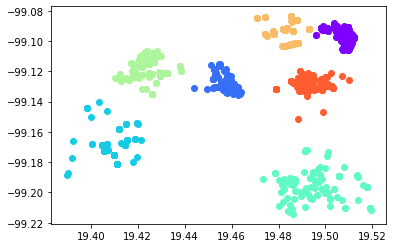

In [16]:
# plot the results
clusters = [c for c in range(best_k)]
colors = cm.rainbow(np.linspace(0, 1, Ks[3] * 5))
colors = colors[::5]
for cluster, c in zip(clusters, colors):
    data = np.array(dict_of_clusters[cluster])
    plt.scatter(data[:, 0], data[:, 1], color=c)

# PART 2 - Order The Clusters 

In [17]:
# centers (centroids) of clusters
centers = best_kmeans.cluster_centers_

In [18]:
# radius of the Earth
R = 6373.0

def compute_distance(place_1, place_2):
    """
    compute the distance between two lat-long coordinates

    Input:

    place_1 - tuple : (latitude, longitude) of place 1
    place_2 - tuple : (latitude, longitude) of place 2

    Returns:
    distance - float number 
    """    
    
    distance_lat = place_2[0] - place_1[0]
    distance_long = place_2[1] - place_1[1]

    #Haverinse formula 
    x = math.sin(distance_lat / 2)**2 + math.cos(place_1[0]) * math.cos(place_2[0]) * math.sin(distance_long / 2)**2

    y = 2 * math.atan2(math.sqrt(x), math.sqrt(1 - x))

    return R * y

### 2a -
- Order the cluster according to the distances between them. 
- All data points in the same cluster will get the same index.

In [19]:
# order the clusters according to distance from cluster 0 

d_array = [(0,0)]
c_0 = centers[0]
for idx, c in enumerate(centers[1:]):
    d_array += [(compute_distance(c_0, c), idx + 1)]
cluster_distance = sorted(d_array, key=lambda x: x[0]) 

dict_cluster_to_idx = {c[1] : idx for idx, c in enumerate(cluster_distance)}

idx_res_column = []

# for each row add the relevent number according to the order of the clusters
for label in labels:
    idx_res_column += [dict_cluster_to_idx[label]]    

In [20]:
# add the column to the dataFrame
df['IDC_Index__c'] = idx_res_column
# save a copy of 2a results

In [21]:
df

,_,Id,AppointmentNumber,Latitude,Longitude,IDC_Index__c,EarliestStartTime,DurationInMinutes
0,[ServiceAppointment],08p4L000000lKo4QAE,SA-5319,19.460891,-99.139634,6,2021-12-21T00:00:00.000+0000,14
1,[ServiceAppointment],08p4L000000lKo5QAE,SA-5320,19.368634,-99.145334,13,2021-12-21T00:00:00.000+0000,14
2,[ServiceAppointment],08p4L000000lKoCQAU,SA-5327,19.493341,-99.190447,8,2021-12-21T00:00:00.000+0000,14
3,[ServiceAppointment],08p4L000000lKoDQAU,SA-5328,19.462779,-99.135322,5,2021-12-21T00:00:00.000+0000,14
4,[ServiceAppointment],08p4L000000lKo9QAE,SA-5324,19.487029,-99.198889,8,2021-12-21T00:00:00.000+0000,14
...,...,...,...,...,...,...,...,...
1569,[ServiceAppointment],08p4L000000lKqvQAE,SA-5496,19.410017,-99.175183,12,2021-12-21T00:00:00.000+0000,14
1570,[ServiceAppointment],08p4L000000lKqwQAE,SA-5497,19.404777,-99.169003,12,2021-12-21T00:00:00.000+0000,14
1571,[ServiceAppointment],08p4L000000lKqsQAE,SA-5493,19.453365,-99.130240,5,2021-12-21T00:00:00.000+0000,14
1572,[ServiceAppointment],08p4L000000lKqtQAE,SA-5494,19.452480,-99.145865,6,2021-12-21T00:00:00.000+0000,14


In [22]:
results_2a_dataframe = df.copy()

In [23]:
# craete result new excel
if export_results:
    df.to_excel(f'results_{name_of_file}_(2a).xlsx', sheet_name='results')

### 2b - 
Order the cluters by executing shortest path algorithm on each cluster. 

In [24]:
# seprate the datapoints according to their cluster
# save id = job's row.
separate_dataset = [[] for cluster in range(best_k)]
id = 0
for datapoint, label in zip(dataset, labels):
    separate_dataset[label].append((id, datapoint))
    id += 1

Greedy - on each cluster index according to the the distance from the first job in the cluster
Shoretest path Algorithm: 
### Dijkstra algorithm

- We execute SP on every cluster according to the order we achieved above.
- Fisrt iteration: 
    - Startpoint: take random datapoint
    - Endpoint: random datapoint from the next cluster
- Next iterations:
    - StartPoint: the endpoint from the previous iteration
    - Endpoint: random datapoint from the next cluster

In [25]:
# save the oredr of the clusters
cluster_order = [c[1] for c in cluster_distance]

In [26]:
MAX_VALUE = sys.float_info.max

In [27]:
class Vertex: 
    
    def __init__(self, job, is_root=False):
        self.id = job[0]
        self.place = job[1]
        self.distance = 0 if (is_root) else MAX_VALUE
        self.parent = None


    def relax(self, v):
        distance_from_self_to_v = compute_distance(self.place, v.place) 
        if v.distance > self.distance + distance_from_self_to_v:
            v.distance = self.distance + distance_from_self_to_v
            v.parent = self.id
            
    # implemt =, < for using heapq on vertex
    def __eq__(self, other):
        if self.distance == other.distance:
            return True
        else:
            return False

    def __lt__(self, other):
        if self.distance < other.distance:
            return True
        else:
            return False

In [28]:
idx = 0
results = []
for cluster in range(best_k):
    root = Vertex(separate_dataset[cluster][0], is_root=True)
    G = [Vertex(datapoint) for datapoint in separate_dataset[cluster][1:]]
    G.append(root)
    # we do not use E since there are edges between all the vertices
    #E = [(v1.id, v2.id) for v1 in G for v2 in G]

    # ------- Execute DIJKSTRA -------- #
    priority_queue = []
    #push all vertices
    for v in G:
        heapq.heappush(priority_queue, v)
    while priority_queue != []:
        # dequeue the smallest vertex (according to the distance field)
        u = heapq.heappop(priority_queue)
        results.append((u.id, idx)) #u.index = idx  ->. at Dijkstra the first to leave th queue is the closet to the begining
        for v in G:
            u.relax(v)
        idx +=1

In [29]:
#sort result according to rows order ('id')
results.sort(key=lambda row: row[0])
results = [row[1] for row in results]

In [30]:
# add the column to the dataFrame
df['IDC_Index__c'] = results

In [31]:
# craete result new excel
if export_results:
    df.to_excel(f'results_{name_of_file}_(2b).xlsx', sheet_name='results')

### 2c -
- For each cluster perform Kmeans inside him and create sub-cluster
- Order the cluster according to the distances between them. 
- All data points in the same sub-cluster will get the same index.

In [32]:
#df = pd.read_excel(f'results_{name_of_file}_(2a).xlsx')
df = results_2a_dataframe.copy()

In [33]:
# K to check for the KMeans
Ks = [k for k in range(2, 10)]

In [34]:
# ignore the warning of dupliacte objects - since there are data points on the same location
warnings.filterwarnings(action='ignore')

dict_of_clusters_2 = dict({})
index_2c = 0
r = 1

for cluster in clusters:        
    dataset = dict_of_clusters[cluster]
    inertia_lst = []
    if(len(dataset) > 10):
        
        best_k_idx, _ = choose_k(Ks)
        best_k = Ks[best_k_idx]
        
        # get the best KMeans , n_clusters=best_k
        best_kmeans = KMeans(n_clusters=best_k, random_state=1)
        
        # get labels 
        labels = best_kmeans.fit(dataset, sample_weight=1).labels_

        # seperate the instances to clusters
        dict_of_clusters_2c = seperate_instances_to_clusters(dataset, labels, best_k)
        
        for cluster, instances in dict_of_clusters_2.items():
            dict_of_clusters_2c.update({index_2c: instances}) 
            index_2c += 1
    
    else:
        dict_of_clusters_2c.update({index_2c: dataset}) 
        index_2c += 1

In [35]:
for cluster, instances in dict_of_clusters_2c.items():
    for instance in instances:
        inds = np.where(np.logical_and(df['Latitude'].values  == instance[0],df['Longitude'].values == instance[1]))[0]
        df['IDC_Index__c'].iloc[inds] = cluster

In [36]:
# craete result new excel
if export_results:
    df.to_excel(f'results_{name_of_file}_(2c).xlsx', sheet_name='results')

# 2d

##### on each cluster from 2a execute 1-TSP algorithm 

In [37]:
# 2-opt Algorithm adapted from https://en.wikipedia.org/wiki/2-opt

# Calculate the euclidian distance in n-space of the route r traversing jobs j, ending at the path start.
path_distance = lambda r,j: np.sum([np.linalg.norm(j[r[p]] - j[r[p - 1]]) for p in range(len(r))])

# Reverse the order of all elements from element i to element k in array r.
two_opt_swap = lambda r,i,k: np.concatenate((r[0:i], r[k:- len(r) + i - 1:-1],r[k + 1:len(r)]))

def two_opt(jobs,improvement_threshold): 
    route = np.arange(jobs.shape[0])
    # Initialize the improvement factor.
    improvement_factor = 1 
    best_distance = path_distance(route,jobs)
    
    while improvement_factor > improvement_threshold: 
        # Record the distance at the beginning of the loop.
        distance_to_beat = best_distance
        
        for swap_first in range(1,len(route)-2):
            for swap_last in range(swap_first+1,len(route)): 
                # try reversing the order of these jobs
                new_route = two_opt_swap(route,swap_first,swap_last) 
                # check the total distance with this modification.
                new_distance = path_distance(new_route,jobs)
                
                if new_distance < best_distance: 
                    route = new_route
                    best_distance = new_distance 
        # Calculate how much the route has improved.
        improvement_factor = 1 - best_distance/distance_to_beat 
    return route

In [38]:
# 1-TSP
def one_TSP(data, offset=0):
    """
    Execute 1-TSP optimal algorithm on the give sub-graph_i
    
    Input:
    Gi - sub-graph i
    offset - the index to start from.
    """
    R = 6371
    
    lat = data["Latitude"].map(math.radians)
    lon = data["Longitude"].map(math.radians)
    x = lon.map(math.cos)*lat.map(math.cos)*R
    y = lon.map(math.cos)*lat.map(math.sin)*R

    data["lat_radians"] = lat
    data["lon_radians"] = lon
    data["x"] = x
    data["y"] = y
    
    jobs_location = data[['x', 'y']].copy()
    
    scaler = MinMaxScaler(feature_range=(0, 100), copy=True)
    scaled_df = scaler.fit_transform(jobs_location)
    scaled_df = pd.DataFrame(scaled_df, columns=['x1', 'x2'])
    
    jobs_location = np.asarray(jobs_location)
    scaled = np.asarray(scaled_df)
    
    route = two_opt(scaled, 0.001)
    
    return route

# Note:

###### we remove the jobs with the same location and give them the same index after that, then the run time of 1-TSP iis faster.

In [39]:
def is_the_same_location(place_1, place_2):
    return True if place_1['Latitude'] == place_2['Latitude'] and place_1['Longitude'] == place_2['Longitude'] else False


def merge_duplicates(df):
    duplicates_indexes = []
    dict_of_duplicates = dict({})
    res = df.copy()
    for index_1, row_1 in df.iterrows():
        if index_1 not in duplicates_indexes:
            current_duplicates = []
            for index_2, row_2 in df.iterrows():
                if index_1 < index_2 and index_2 not in duplicates_indexes and is_the_same_location(row_1, row_2):
                        res.drop(index=index_2, axis=0, inplace=True)
                        current_duplicates.append(index_2)
            duplicates_indexes += current_duplicates
            dict_of_duplicates[index_1] = current_duplicates
    return res, dict_of_duplicates

In [40]:
# df = pd.read_excel(f'results_{name_of_file}_(2a).xlsx')
df = results_2a_dataframe.copy()
# get IDC_index column number 
idc_index_col_number = [i for i in range(len(df.columns)) if df.columns[i] == 'IDC_Index__c'][0]
unique_df, dict_of_duplicates = merge_duplicates(df)
num_of_clusters = max(unique_df['IDC_Index__c'])
unique_df = unique_df[['Latitude', 'Longitude', 'IDC_Index__c']]
data = pd.DataFrame({})
offset = 0
for i in range(num_of_clusters):
    current_df_cluster = unique_df[unique_df['IDC_Index__c'] == i].copy()
    indexes = list(current_df_cluster.index)
    results = one_TSP(current_df_cluster, offset)
    # handle same place case -> results do not consider it  
    for idx, res in zip(indexes, results):
        lat = unique_df['Latitude'][idx]
        lon = unique_df['Longitude'][idx]
        df.iloc[idx, idc_index_col_number] = res + offset
    offset += current_df_cluster.shape[0]

for key, values in dict_of_duplicates.items():
    if values:
        for value_idx in values:
            df.iloc[value_idx, idc_index_col_number] = df.iloc[key, idc_index_col_number] 

In [41]:
# craete result new excel
# if export_results:
df.to_excel(f'results_{name_of_file}_(2d).xlsx', sheet_name='results')